In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import fiona

# !pip install pyogrio
# import pyogrio

from shapely.geometry import Point, Polygon
import seaborn as sns

from sklearn.cluster import KMeans
import math
import csv

from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split
!pip install catboost

from catboost import CatBoostRegressor, Pool
import catboost as cb
from sklearn.metrics import mean_squared_error

# Load Data and Preprocess

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
barcelona_df = pd.read_csv("/content/drive/MyDrive/AIT Classes/Data Science/Project/la_listings.csv")
# barcelona_df = pd.read_csv("/content/drive/MyDrive/AIT Classes/Data Science/Project/Barcelona_listings.csv")


In [4]:
# convert price to float
price_list = []
for price in barcelona_df['price']:
    cleaned = price.replace(',', '')
    price_list.append(float(cleaned[1:]))

barcelona_df['price_float'] = price_list

In [5]:
print(barcelona_df.shape)
barcelona_df = barcelona_df[barcelona_df['price_float'] <= 500.0]
print(barcelona_df.shape)

(45591, 76)
(41294, 76)


# Feature Extraction: Distance to City Center

In [6]:
# load Barcelona Map
street_map = gpd.read_file('/content/drive/MyDrive/AIT Classes/Data Science/Project/la.shp')

In [7]:
# Plot the listings in the map
geometry = [Point(xy) for xy in zip(barcelona_df['longitude'], barcelona_df['latitude'])]
geo_df = gpd.GeoDataFrame(barcelona_df, geometry=geometry) #specify the geometry list we created

Text(0.5, 1.0, 'Loacations of the listing across the city')

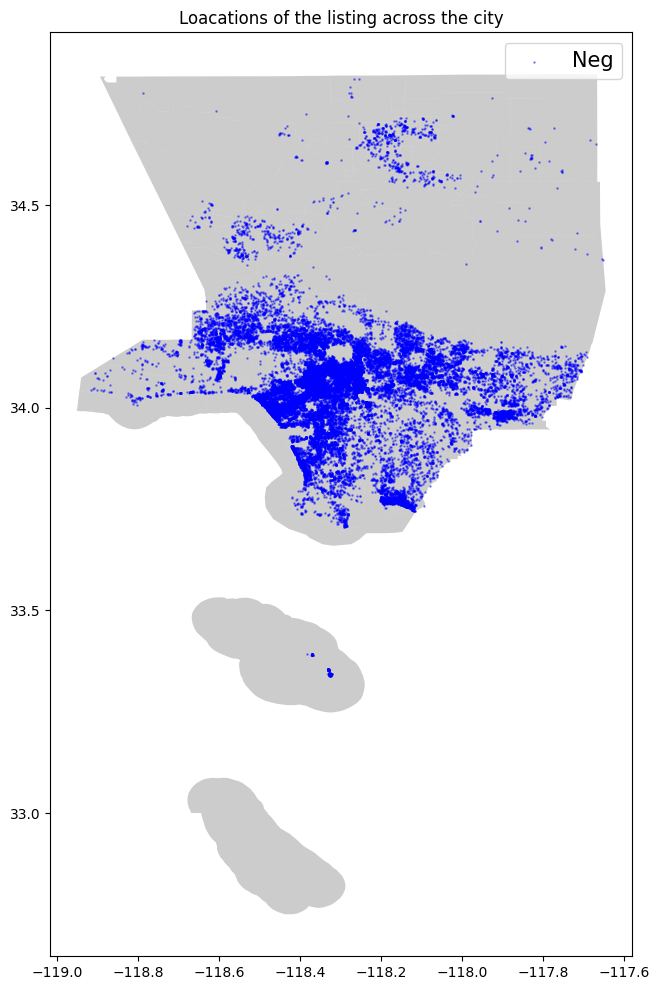

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df.plot(ax=ax, markersize=3, color='blue', marker='.', label='Neg', alpha=0.4)
plt.legend(prop={'size':15})
plt.title('Loacations of the listing across the city')

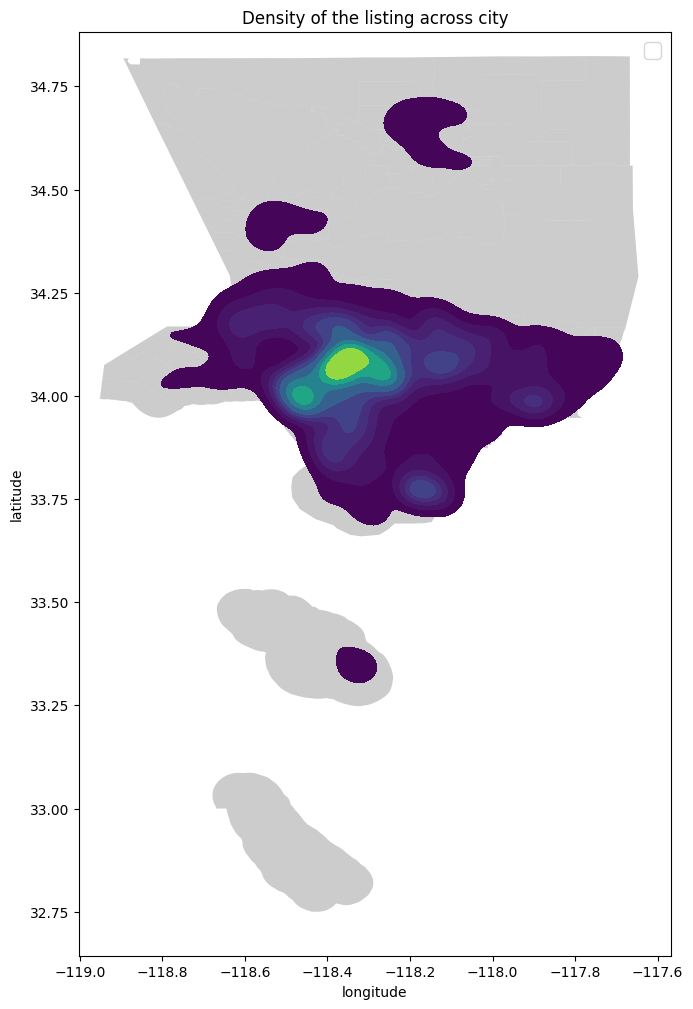

In [9]:
# Density of the listing across city
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

kde = sns.kdeplot(data=geo_df, x='longitude', y='latitude', fill=True, cmap='viridis', ax=ax, thresh=0.025)#.0025
# cbar = plt.colorbar(kde.collections[0], ax=ax, label='Density')
plt.title('Density of the listing across city')
plt.legend(prop={'size':15})

In [36]:
# Kmeans clustering
coordinates = barcelona_df[['latitude', 'longitude']]

num_clusters = 2
kmean_cluster = KMeans(n_clusters=num_clusters, random_state=42)
barcelona_df['cluster'] = kmean_cluster.fit_predict(coordinates)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


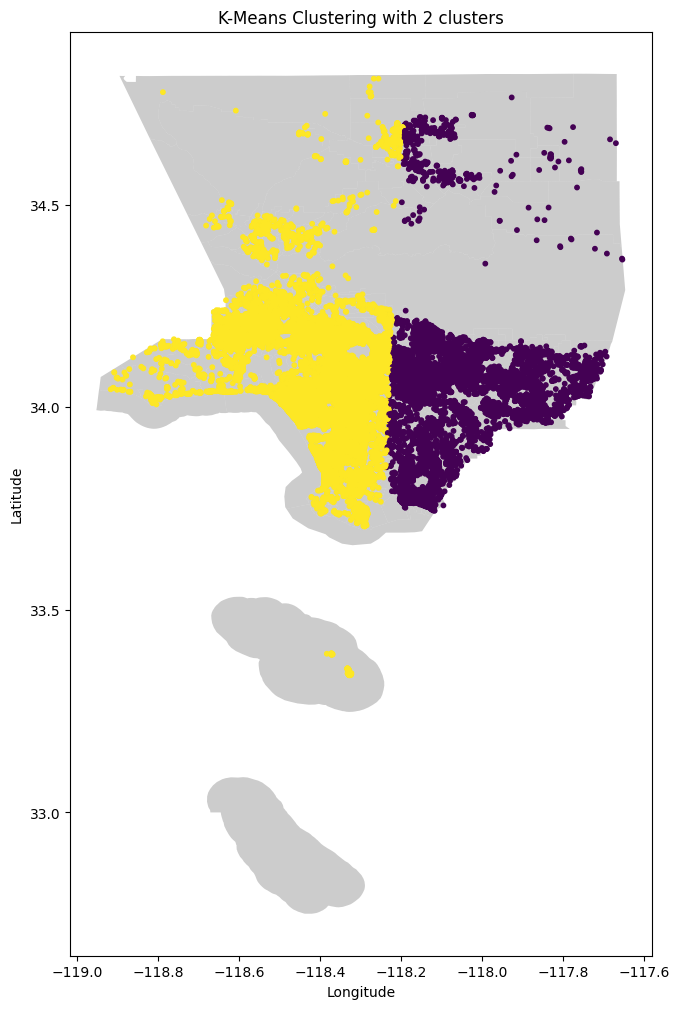

In [37]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=10)
plt.title(f'K-Means Clustering with {num_clusters} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [38]:
densest_cluster = np.argmax(np.bincount(barcelona_df['cluster']))
densest_cluster_lat_longs = coordinates[barcelona_df['cluster'] == densest_cluster]
centroid = [np.mean(densest_cluster_lat_longs['latitude']), np.mean(densest_cluster_lat_longs['longitude'])] # [latitude, longitude]
print(f"Coordinates of the densest spot (centroid of the densest cluster): {centroid}")

Coordinates of the densest spot (centroid of the densest cluster): [34.057963197494814, -118.38174119441075]


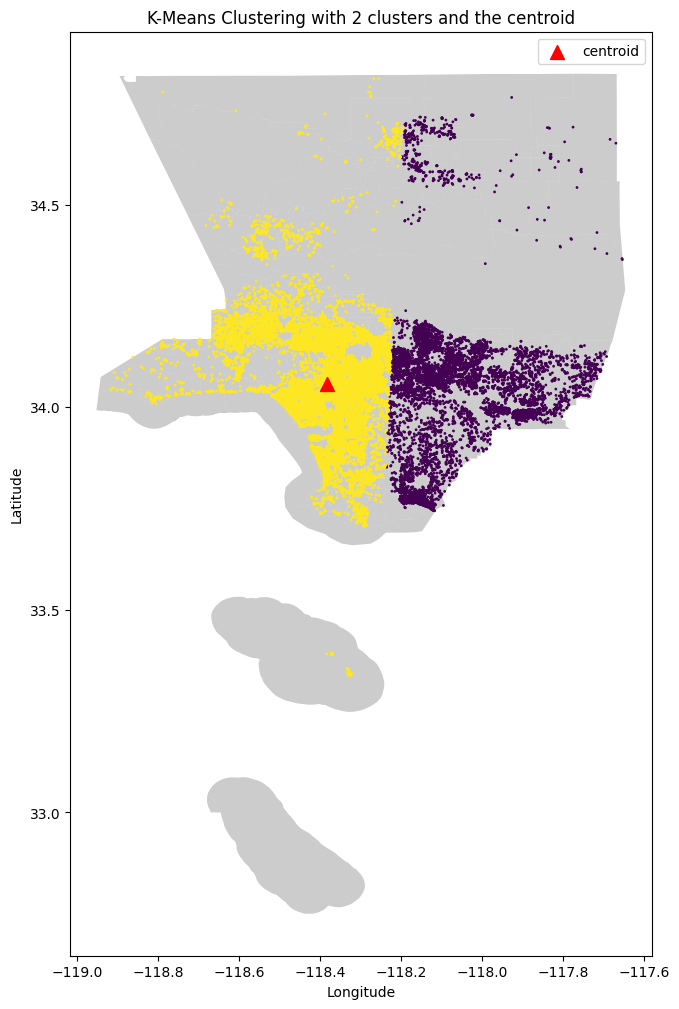

In [39]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=1)
plt.scatter(centroid[1], centroid[0], c = 'red', marker='^', s = 100, label = 'centroid')
plt.title(f'K-Means Clustering with {num_clusters} clusters and the centroid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [40]:
print(centroid)

[34.057963197494814, -118.38174119441075]


In [41]:
# adding distance to city center to the dataframe
dist_to_cen = []
for i in range(len(barcelona_df)):
    dist_to_cen.append(math.dist(centroid, [barcelona_df.iloc[i][30], barcelona_df.iloc[i][31]]))

print(min(dist_to_cen))
print(dist_to_cen)
barcelona_df['to_city_center'] = dist_to_cen

0.0005328939175356293
[0.07507809515781655, 0.05234253150676352, 0.11274485900614593, 0.3233929486157316, 0.08008043501422772, 0.08655061952667811, 0.08655061952667811, 0.05480287120147221, 0.025181032780063842, 0.28546406444199146, 0.04920756678523511, 0.07696932323312376, 0.19026129436893946, 0.050257886861370706, 0.36646676366408715, 0.1332505877261341, 0.07609079117536056, 0.3451056970887005, 0.11263939939011994, 0.10595244432465141, 0.027001466540608955, 0.026331199771764884, 0.06580843279629921, 0.2213342314419343, 0.10976580193582726, 0.284431675483999, 0.21870239891688933, 0.08637730454049614, 0.018477039263396604, 0.10608849681592375, 0.030819979712576693, 0.10041269922797184, 0.09808371555001195, 0.21870239891688933, 0.03329242325469541, 0.04491092590364472, 0.24170979789104313, 0.2213342314419343, 0.09949161663106004, 0.09547209052606848, 0.1194226912807585, 0.09664464224066381, 0.16565020167509076, 0.08892362753478085, 0.252514059678657, 0.12022492493770914, 0.1007649300056

# dropping useless features

In [42]:
# insights about barcelona_df: bathrooms has only NaNs, create categoricals into strings, feature extraction on amenities,
not_useful = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location',
            'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'neighbourhood', 'bathrooms', 'price', 'calendar_updated',
             'calendar_last_scraped', 'first_review', 'last_review', 'license', 'cluster' ]

# dropped for now / for this project
might_be_useful = ['name', 'description', 'neighborhood_overview', 'host_about' ]

# host_since: date handling, host_response_time = categorical integration possible, host_neighbourhood: have to see if whether useful or not
# amenities: feature extraction possible,
flagged_col = ['host_since', 'host_response_time', 'host_neighbourhood', 'latitude', 'longitude', 'amenities', ]

# host_response_rate, host_acceptance_rate: format %, host_has_profile_pic: format datatype('0'), property_type: drop low frequency unique values
to_format = ['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
            'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'has_availability', 'instant_bookable',  ]

TO_DROP = not_useful + might_be_useful + flagged_col + to_format

integrated_directly = ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                      'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                      'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price_float', 'to_city_center']

print(len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly))
print(len(barcelona_df.columns))
print(barcelona_df.columns[len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly)-1])

78
78
to_city_center


In [43]:
pre_filtered_barcelona_df = barcelona_df.drop(columns=(not_useful + might_be_useful + flagged_col), axis=1)

print(pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.head()

(41294, 46)


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center
0,NaN,50%,f,1.0,3.0,t,t,Culver City,Other Cities,Entire condo,...,5.00,4.00,f,1,1,0,0,0.01,129.0,0.075078
1,NaN,100%,t,2.0,3.0,t,t,Hollywood,City of Los Angeles,Private room in rental unit,...,4.95,4.88,t,2,0,2,0,0.35,94.0,0.052343
2,100%,42%,f,2.0,2.0,t,t,Santa Monica,Other Cities,Private room in rental unit,...,4.91,4.22,f,2,1,1,0,0.16,179.0,0.112745
3,NaN,NaN,f,1.0,1.0,t,t,Bellflower,Other Cities,Entire rental unit,...,NaN,NaN,f,1,1,0,0,NaN,50.0,0.323393
4,100%,96%,t,3.0,4.0,t,t,Hollywood Hills,City of Los Angeles,Private room in home,...,4.97,4.90,f,3,1,2,0,1.02,220.0,0.080080


# fix/convert some useful attributes

In [44]:
# response rate and acceptance rate
resp_rate = []
accept_rate = []

for r_rate in pre_filtered_barcelona_df['host_response_rate']:
  r = str(r_rate)
  if (r == 'nan'):
    resp_rate.append(int(0))
  else:
    resp_rate.append(int(r[:-1]))

for a_rate in pre_filtered_barcelona_df['host_acceptance_rate']:
  a = str(a_rate)
  if (a == 'nan'):
    accept_rate.append(int(0))
  else:
    accept_rate.append(int(a[:-1]))

pre_filtered_barcelona_df['host_response_rate'] = resp_rate
pre_filtered_barcelona_df['host_acceptance_rate'] = accept_rate

print(pre_filtered_barcelona_df.shape)

(41294, 46)


In [45]:
def to_binary_encoding(df, name):
  tracker = []
  for val in df[name]:
    if (str(val) == 't'):
      tracker.append(int(1))
    else:
      tracker.append(int(0))
  return tracker

formatted = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
for fr in formatted:
  pre_filtered_barcelona_df[f'{fr}_formatted'] = to_binary_encoding(pre_filtered_barcelona_df, fr)
pre_filtered_barcelona_df.drop(columns=formatted, inplace=True)

In [46]:
pre_filtered_barcelona_df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center,host_is_superhost_formatted,host_has_profile_pic_formatted,host_identity_verified_formatted,has_availability_formatted,instant_bookable_formatted
0,0,50,1.0,3.0,Culver City,Other Cities,Entire condo,Entire home/apt,6,2 baths,...,0,0,0.01,129.0,0.075078,0,1,1,1,0
1,0,100,2.0,3.0,Hollywood,City of Los Angeles,Private room in rental unit,Private room,1,1 shared bath,...,2,0,0.35,94.0,0.052343,1,1,1,1,1
2,100,42,2.0,2.0,Santa Monica,Other Cities,Private room in rental unit,Private room,1,1 private bath,...,1,0,0.16,179.0,0.112745,0,1,1,1,0
3,0,0,1.0,1.0,Bellflower,Other Cities,Entire rental unit,Entire home/apt,2,1 bath,...,0,0,NaN,50.0,0.323393,0,1,1,0,0
4,100,96,3.0,4.0,Hollywood Hills,City of Los Angeles,Private room in home,Private room,3,1 private bath,...,2,0,1.02,220.0,0.080080,1,1,1,1,0


In [47]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(pre_filtered_barcelona_df)
print(categorical_indicies)

[4, 5, 6, 7, 9]


In [48]:
cat_names = []
for cat_i in categorical_indicies:
  print(pre_filtered_barcelona_df.columns[cat_i])
  cat_names.append(pre_filtered_barcelona_df.columns[cat_i])

print(' ====> dimension before dropping: ', pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.drop(columns=cat_names, inplace=True)
print(' ====> dimension after droppnig: ', pre_filtered_barcelona_df.shape)

neighbourhood_cleansed
neighbourhood_group_cleansed
property_type
room_type
bathrooms_text
 ====> dimension before dropping:  (41294, 46)
 ====> dimension after droppnig:  (41294, 41)


In [49]:
col_used = pre_filtered_barcelona_df.columns
with open('/content/sample_data/columns_used.txt', 'w') as file:
  for i, col in enumerate(col_used):
    file.write(f'{i+1}: {col}\n')

In [50]:
print(pre_filtered_barcelona_df.shape)

(41294, 41)


# Train Model

In [51]:
y = pre_filtered_barcelona_df['price_float']
pre_filtered_barcelona_df = pre_filtered_barcelona_df.drop(columns='price_float',axis=1)
X = pre_filtered_barcelona_df

In [52]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create CatBoost Pools for training, validation, and test sets
train_pool = cb.Pool(X_train, label=y_train)
val_pool = cb.Pool(X_val, label=y_val)
test_pool = cb.Pool(X_test, label=y_test)

# Create a CatBoostRegressor
catboost_regressor = CatBoostRegressor(iterations=300, depth=7, learning_rate=0.1, loss_function='RMSE', random_seed=42)

# Train the model using the training Pool and validate on the validation set
catboost_regressor.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=10)

# Make predictions on the test set
y_pred = catboost_regressor.predict(test_pool)

0:	learn: 96.2547225	test: 97.0119335	best: 97.0119335 (0)	total: 40.9ms	remaining: 12.2s
10:	learn: 77.1273513	test: 77.7950236	best: 77.7950236 (10)	total: 380ms	remaining: 9.99s
20:	learn: 72.1985815	test: 73.0344058	best: 73.0344058 (20)	total: 748ms	remaining: 9.93s
30:	learn: 69.8759740	test: 71.0040981	best: 71.0040981 (30)	total: 1.08s	remaining: 9.4s
40:	learn: 68.4445569	test: 69.6961480	best: 69.6961480 (40)	total: 1.45s	remaining: 9.16s
50:	learn: 67.4114812	test: 68.8759782	best: 68.8759782 (50)	total: 1.82s	remaining: 8.88s
60:	learn: 66.6163596	test: 68.2458197	best: 68.2458197 (60)	total: 2.2s	remaining: 8.63s
70:	learn: 65.9769475	test: 67.8193843	best: 67.8193843 (70)	total: 2.6s	remaining: 8.4s
80:	learn: 65.4335138	test: 67.4439275	best: 67.4439275 (80)	total: 2.8s	remaining: 7.58s
90:	learn: 64.9512598	test: 67.0605190	best: 67.0605190 (90)	total: 2.96s	remaining: 6.79s
100:	learn: 64.5406984	test: 66.7950143	best: 66.7950143 (100)	total: 3.11s	remaining: 6.13s
110

In [53]:
print(len(pre_filtered_barcelona_df.columns))

40


# Save dataframe with overpricing and prediction data


In [54]:
y_pred_all = catboost_regressor.predict(pre_filtered_barcelona_df)

# Add the predictions as a new column named 'prediction' to pre_filtered_barcelona_df
pre_filtered_barcelona_df['prediction'] = y_pred_all

# logging overpriced/underpriced (1 for overpriced and 0 for underpriced)
pre_filtered_barcelona_df['price_float'] = y

pre_filtered_barcelona_df['overpriced'] = np.where(pre_filtered_barcelona_df['price_float'] > pre_filtered_barcelona_df['prediction'], 1, 0)

pre_filtered_barcelona_df['latitude'] = barcelona_df['latitude']
pre_filtered_barcelona_df['longitude'] = barcelona_df['longitude']

pre_filtered_barcelona_df.to_csv('/content/drive/MyDrive/AIT Classes/Data Science/Project/predictions/la_listing_and_predictions.csv', index=False)

In [55]:
pre_filtered_barcelona_df['overpriced']


0        0
1        1
2        1
3        0
4        1
        ..
45585    0
45586    0
45588    0
45589    0
45590    0
Name: overpriced, Length: 41294, dtype: int64

# Evalutaion

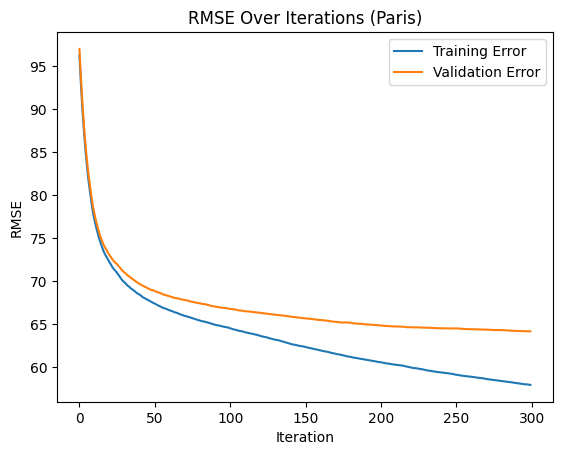

In [56]:
iterations = range(len(catboost_regressor.get_evals_result()['learn']['RMSE']))

plt.plot(iterations, catboost_regressor.get_evals_result()['learn']['RMSE'], label='Training Error')
plt.plot(iterations, catboost_regressor.get_evals_result()['validation']['RMSE'], label='Validation Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Iterations (Paris)')
plt.legend()
plt.show()

In [57]:
feature_importance = catboost_regressor.get_feature_importance()
print(feature_importance)

[ 1.63670421  2.01961685  2.44569138  3.55557492 21.17799267  0.
  5.99877637  2.54285103  1.29200678  1.91757551  2.29060016  0.8981991
  0.36983495  2.0379709   0.49529951  1.52073522  0.9457458   0.85181452
  1.46110001  2.24218342  2.17907157  0.74616109  2.19501059  1.0798084
  1.37884431  0.85238212  0.17991899  5.28543345  2.05709605  2.31504289
  4.78199093  5.30484316  1.31754388  2.69579293  7.70742609  1.01184719
  0.11121665  0.29388398  1.67812793  1.12828447]


In [58]:
print(len(feature_importance))
print(len(X.columns))

40
45


Text(0.5, 1.0, 'Feature Importance in the Model (Paris)')

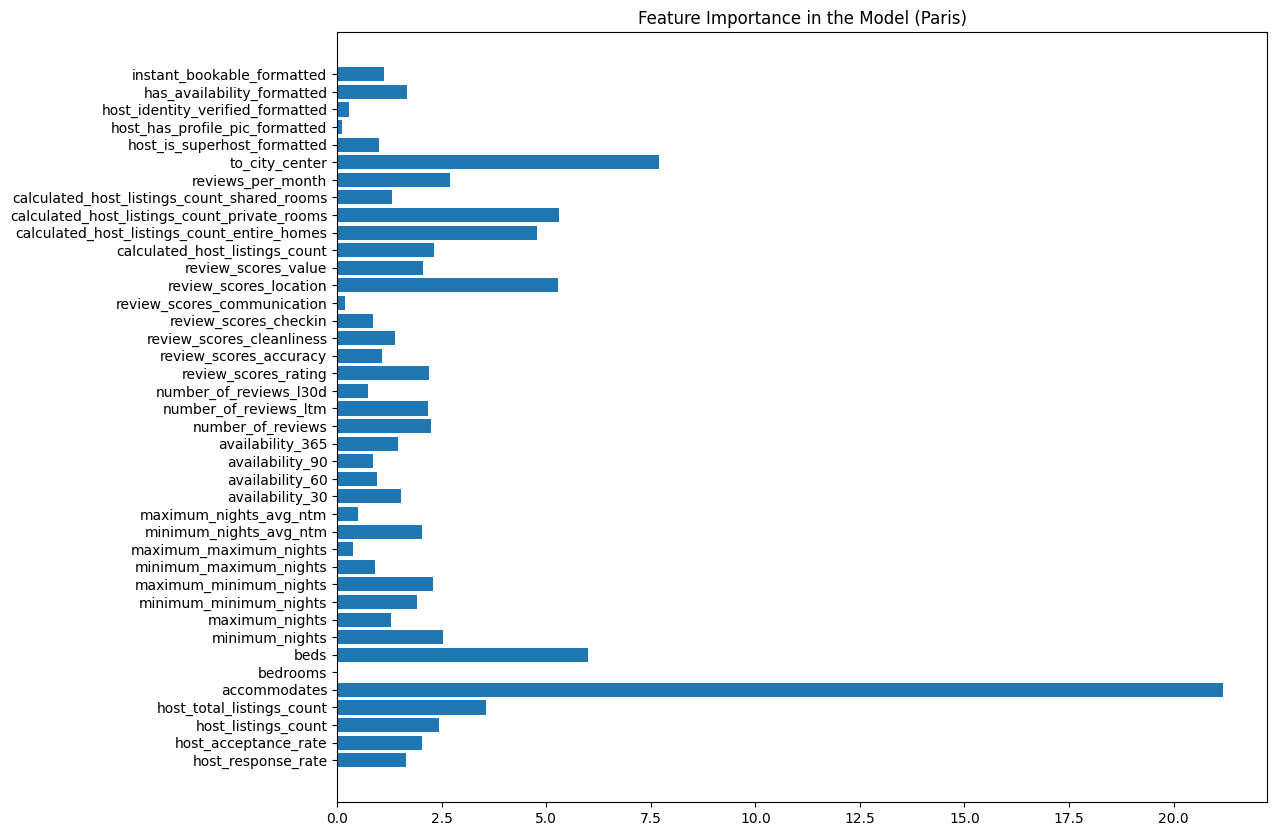

In [59]:
plt.figure(figsize=(12,10))
plt.barh([i for i in X.columns][:40], feature_importance)
plt.title("Feature Importance in the Model (Paris)")

In [65]:
# create a dict containig feature importance
import csv
feature_importance_zipped = zip([i for i in X.columns], feature_importance)
sorted_feature_importance = sorted(feature_importance_zipped, key=lambda x: x[1], reverse=True)

csv_file = '/content/drive/MyDrive/AIT Classes/Data Science/Project/feature_importance/la_feature_importance.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Key', 'Value'])
    for i in sorted_feature_importance:
      to_write = [i[0], i[1]]
      writer.writerow(to_write)

Text(0.5, 1.0, 'Performance of prediction set against test set')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


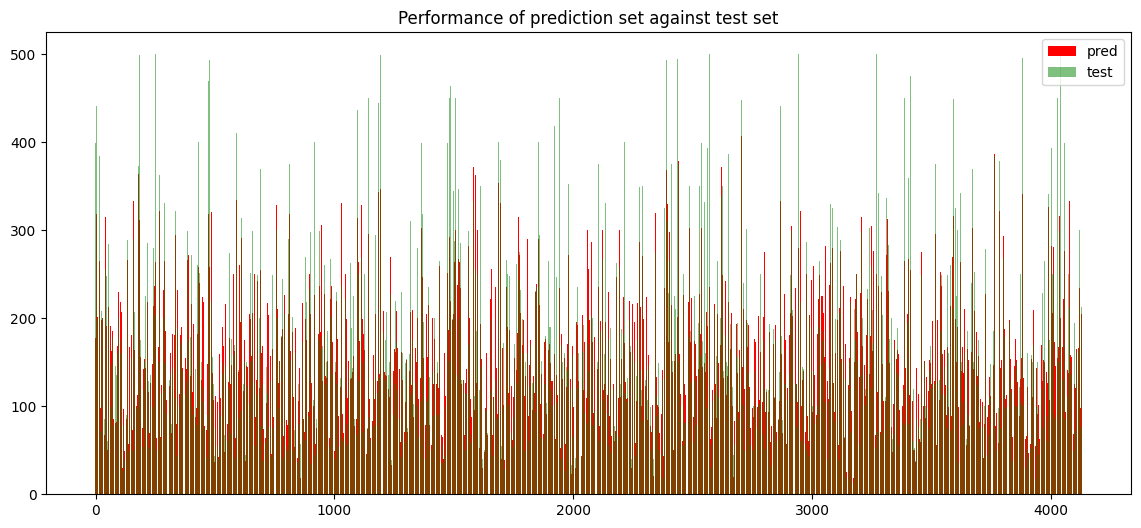

In [63]:
plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_pred))], y_pred, color='red', label='pred')
plt.bar([i for i in range(len(y_test))], y_test, color='green', alpha=.5, label='test')
plt.legend()
plt.title('Performance of prediction set against test set')

Text(0.5, 1.0, 'Absolute error for each listing in test set')

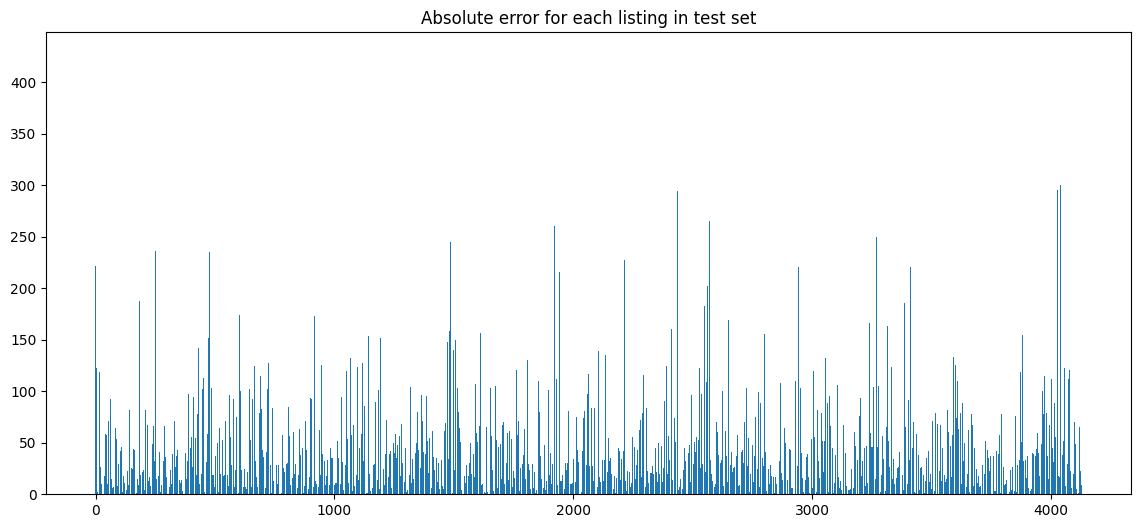

In [66]:
crude_error = []
y_t = y_test.tolist()
y_p = y_pred.tolist()
for i in range(len(y_t)):
  crude_error.append(abs(y_t[i] - y_p[i]))

plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_t))], crude_error)
plt.title('Absolute error for each listing in test set')

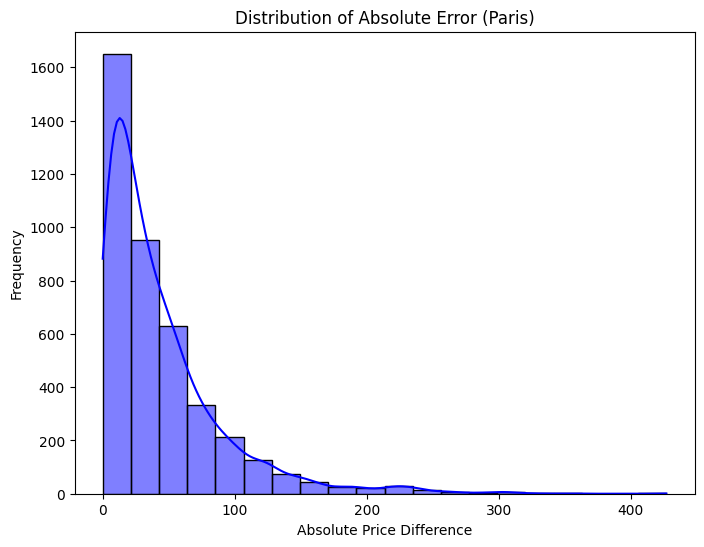

In [68]:
plt.figure(figsize=(8,6))
sns.histplot(crude_error, bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Absolute Error (Paris)')
plt.xlabel('Absolute Price Difference')
plt.ylabel('Frequency')
plt.show()